<a href="https://colab.research.google.com/github/jakeliu15/rlmarketpredictor/blob/main/Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-jsmsrqw9
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-jsmsrqw9
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit fb330fab0d6336c190f1173dcdc36c729e95352b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-akj8__2s/elegantrl_0b2d39049ac245a8b99889c36dbcc83f
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-akj8__2s/elegantrl_0b2d39049ac245a8b99889c36dbcc83f
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit da160146f83d9ce83e60c63268eea97d7dc8cbf4
  Preparing metadata (setup.py) ... done


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Backtesting

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/rlmarketpredictor/train.csv')
trade = pd.read_csv('/content/drive/MyDrive/rlmarketpredictor/trade.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [ ]:
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trained_a2c = A2C.load('/content/drive/MyDrive/rlmarketpredictor/trained_models/agent_a2c.zip') if if_using_a2c else None
trained_ddpg = DDPG.load('/content/drive/MyDrive/rlmarketpredictor/trained_models/agent_ddpg.zip') if if_using_ddpg else None
trained_ppo = PPO.load('/content/drive/MyDrive/rlmarketpredictor/trained_models/agent_ppo.zip') if if_using_ppo else None
trained_td3 = TD3.load('/content/drive/MyDrive/rlmarketpredictor/trained_models/agent_td3.zip') if if_using_td3 else None
trained_sac = SAC.load('/content/drive/MyDrive/rlmarketpredictor/trained_models/agent_sac.zip') if if_using_sac else None

## Out-of-Sample Performance

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment=e_trade_gym) if if_using_ppo else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment=e_trade_gym) if if_using_sac else (None, None)


hit end!
hit end!
hit end!


# Mean Variance Optimization

MVO will be the baseline to compare our agent performance

In [ ]:
# Helps us process data into a form for weight calculation
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 88.79605103, 143.93499756, 115.2043457 , ...,  52.42576599,
        197.26820374,  16.28933716],
       [ 88.79605103, 144.51499939, 116.72138977, ...,  52.7110405 ,
        198.77156067,  16.38739586],
       [ 91.17136383, 152.852005  , 118.28412628, ...,  53.0765152 ,
        203.05036926,  16.61076927],
       ...,
       [162.49176025, 102.56999969, 213.78309631, ...,  28.18767166,
        272.19552612,  16.10049629],
       [162.48182678, 104.98000336, 211.39718628, ...,  28.35359383,
        291.91192627,  15.81544685],
       [167.09553528, 109.81999969, 209.57839966, ...,  29.14417839,
        301.26113892,  16.19244576]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.158 0.066 0.103 0.033 0.076 0.103 0.038]
Variance-Covariance matrix of returns
 [[3.156 1.592 1.722 1.303 1.218 1.674 1.561 0.876]
 [1.592 4.533 1.657 1.299 1.158 1.516 1.808 0.761]
 [1.722 1.657 4.019 1.577 1.513 1.929 1.711 1.187]
 [1.303 1.299 1.577 2.373 1.166 1.501 1.366 0.953]
 [1.218 1.158 1.513 1.166 2.052 1.399 1.296 0.944]
 [1.674 1.516 1.929 1.501 1.399 3.289 1.9   1.034]
 [1.561 1.808 1.711 1.366 1.296 1.9   2.759 0.916]
 [0.876 0.761 1.187 0.953 0.944 1.034 0.916 1.577]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Calculate the efficient Frontier to get weights

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(8)])

mvo_weights

array([412090., 358860.,      0., 229050.,      0.,      0.,      0.,
            0.])

### Apply the weights to the last price of our stock data

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio

array([4632.081, 2601.547,    0.   , 1013.14 ,    0.   ,    0.   ,
          0.   ,    0.   ])

### Test our MVO weights on the out-of-sample data

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

MVO_result

,Mean Var
2020-07-01,1.012656e+06
2020-07-02,1.014485e+06
2020-07-06,1.048137e+06
2020-07-07,1.037411e+06
2020-07-08,1.059415e+06
...,...
2023-04-21,1.328985e+06
2023-04-24,1.330017e+06
2023-04-25,1.308205e+06
2023-04-26,1.306382e+06


# DOW JONES Index as Another Baseline

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^dji']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (712, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None

df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None

df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None




result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)


result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

<ipython-input-21-7bc48f6373a3>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


# Merge DataFrames and view Results

In [ ]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Variance')
col_name.append('DJI')

result.columns = col_name

In [ ]:
result

,A2C,PPO,SAC,Mean Variance,DJI
date,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.012656e+06,1.000000e+06
2020-07-02,1.000366e+06,1.000066e+06,1.000206e+06,1.014485e+06,1.003590e+06
2020-07-06,1.003576e+06,1.000710e+06,1.003439e+06,1.048137e+06,1.021452e+06
2020-07-07,1.000780e+06,1.000132e+06,1.000765e+06,1.037411e+06,1.006031e+06
2020-07-08,1.005198e+06,1.000883e+06,1.005719e+06,1.059415e+06,1.012913e+06
...,...,...,...,...,...
2023-04-24,1.277782e+06,1.047501e+06,1.318530e+06,1.330017e+06,1.316318e+06
2023-04-25,1.263518e+06,1.027013e+06,1.294277e+06,1.308205e+06,1.302929e+06
2023-04-26,1.294484e+06,1.012586e+06,1.328396e+06,1.306382e+06,1.294032e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

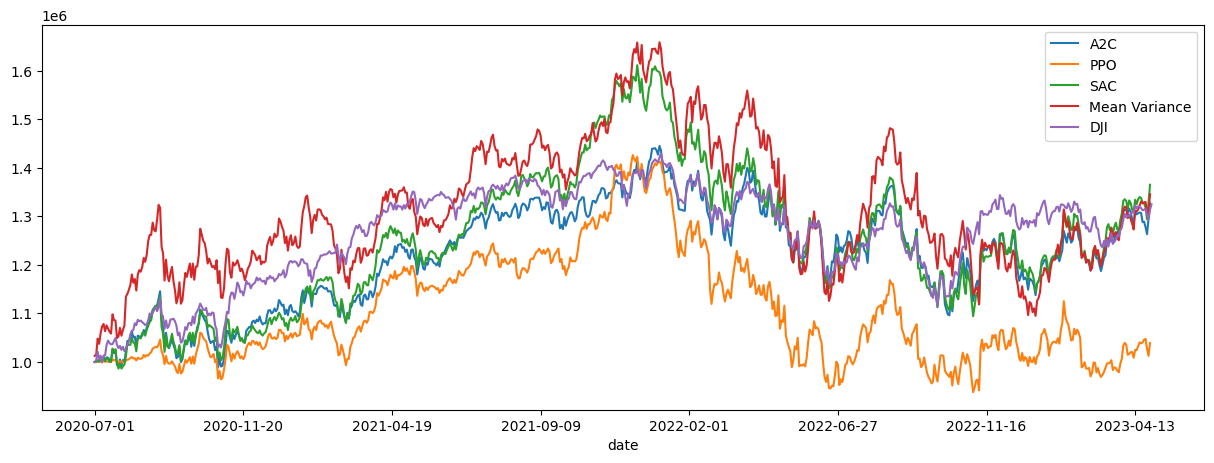

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()